# Analisis Data

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from pymongo import MongoClient
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix

## Deklarasi variabel dan .env

In [2]:
# Nama database dan collection
db_name = 'youtube_rewind_indonesia'
full_labeling_all_collection_name = "full_labeling_all_new"
data_train_collection_name = "data_training_new"
data_test_collection_name = "data_testing_new"

# Memuat value dari file .env
load_dotenv()

mongodb_url = os.getenv('URL_SANDY')
local_url = os.getenv('URL_LOCAL')

## Membuat koneksi ke MongoDB

In [3]:
client = MongoClient(local_url)
db = client[db_name]
data_train_collection = db[data_train_collection_name]
data_test_collection = db[data_test_collection_name]

# Mengambil data dari koleksi MongoDB
data_train = list(data_train_collection.find())
data_test = list(data_test_collection.find())

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

## Train model dengan Naive Bayes 

In [4]:
# Vectorizer
vectorizer = CountVectorizer()

# Mengubah teks menjadi fitur vektor
X_train = vectorizer.fit_transform(df_train['textOriginal'])
y_train = df_train['label']

X_test = vectorizer.transform(df_test['textOriginal'])
y_test = df_test['label']

# Model Naive Bayes
model = MultinomialNB()

# Training
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.6538912788423934
Classification Report:
              precision    recall  f1-score   support

     negatif       0.49      0.71      0.58       557
      netral       0.72      0.48      0.58      1000
     positif       0.73      0.80      0.76      1000

    accuracy                           0.65      2557
   macro avg       0.65      0.66      0.64      2557
weighted avg       0.68      0.65      0.65      2557



# Predicted Label All Data From Model

In [5]:
# Membuat koneksi ke MongoDB
client = MongoClient(local_url)
db = client[db_name]
labeling_all_collection = db[full_labeling_all_collection_name]

# Mengambil data yang belum memiliki label dari koleksi MongoDB
data_unlabeled = list(labeling_all_collection.find())

# Membuat DataFrame dari data yang belum memiliki label
df_unlabeled = pd.DataFrame(data_unlabeled)

# Vectorizer yang sama seperti yang digunakan untuk training
vectorizer = CountVectorizer(vocabulary=vectorizer.vocabulary_)  # Gunakan vocabulary yang sama
X_unlabeled = vectorizer.transform(df_unlabeled['textOriginal'])

# Model Naive Bayes yang telah dilatih sebelumnya
model = MultinomialNB()
model.fit(X_train, y_train)  # Pastikan model sudah dilatih dengan data training yang sesuai

# Melakukan prediksi label untuk data yang belum memiliki label
y_pred_unlabeled = model.predict(X_unlabeled)

# Menambahkan hasil prediksi label ke dalam koleksi MongoDB
for idx, doc in enumerate(data_unlabeled):
    predicted_label = y_pred_unlabeled[idx]
    labeling_all_collection.update_one({"_id": doc["_id"]}, {"$set": {"predicted_label": predicted_label}})

print("Labeling proses selesai.")

Labeling process completed.


# Visualisasi Data Pembuatan Model Machine Learning

## Confusion Matrix

Menunjukkan performa model dalam bentuk matriks kesalahan.

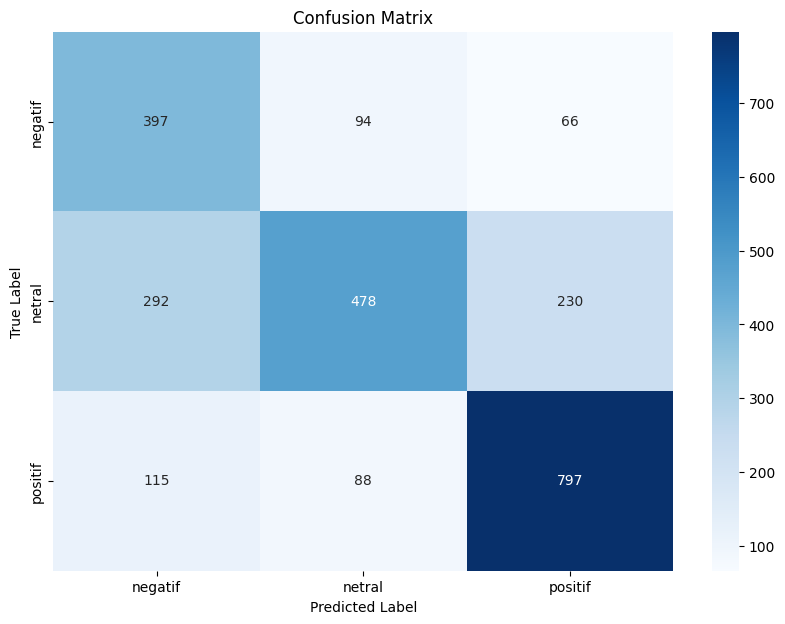

In [6]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Bar Chart dari Prediksi

Menghitung jumlah prediksi untuk setiap label

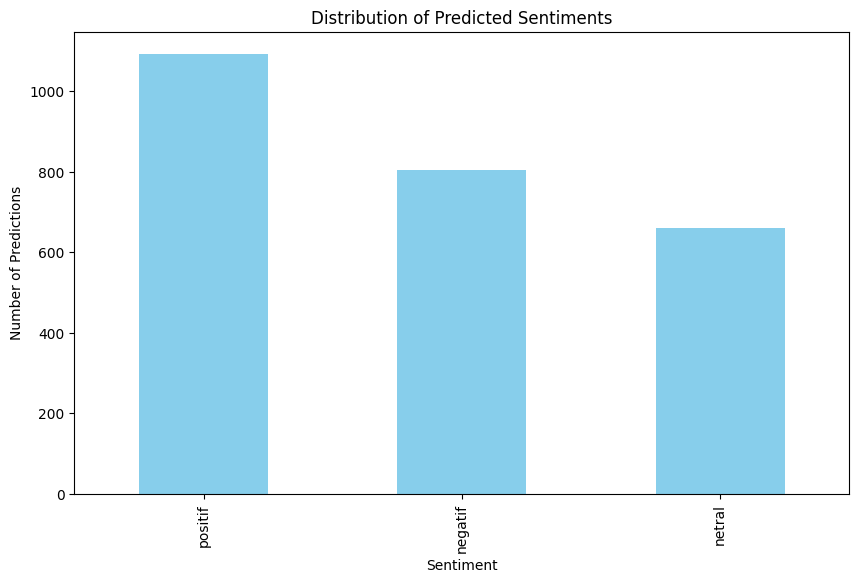

In [7]:
# Menghitung jumlah prediksi untuk setiap label
pred_counts = pd.Series(y_pred).value_counts()

# Plot Bar Chart
plt.figure(figsize=(10, 6))
pred_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predicted Sentiments')
plt.show()


## ROC Curve dan AUC

Untuk tugas klasifikasi biner, ROC Curve dan Area Under the Curve (AUC) adalah metrik yang berguna untuk mengevaluasi kinerja model.

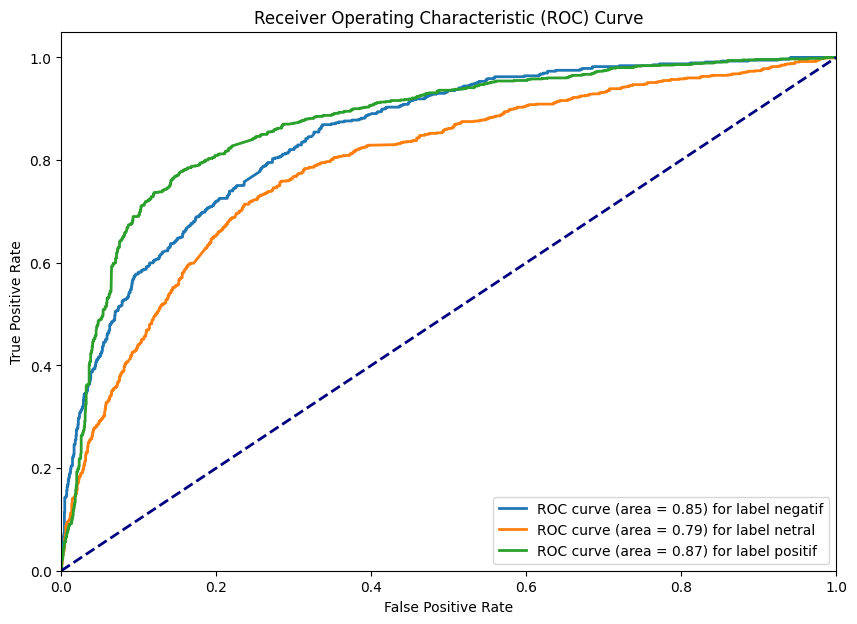

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=model.classes_)
y_pred_proba = model.predict_proba(X_test)

# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f}) for label {label}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Calculate text lengths

Visualisasi distribusi panjang teks dalam data latih dan uji.

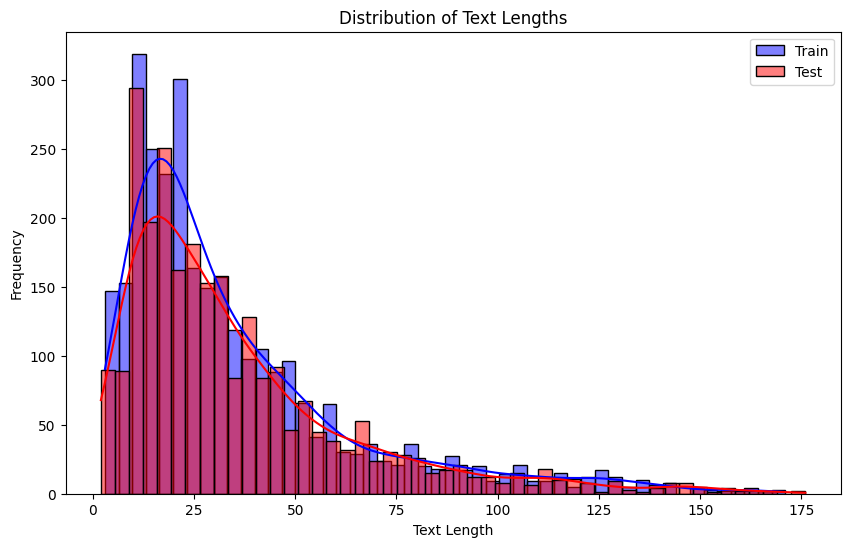

In [10]:
df_train['text_length'] = df_train['textOriginal'].apply(len)
df_test['text_length'] = df_test['textOriginal'].apply(len)

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, color='blue', label='Train', kde=True)
sns.histplot(df_test['text_length'], bins=50, color='red', label='Test', kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.show()


## Word Cloud

Menampilkan kata-kata yang paling sering muncul dalam teks berdasarkan sentimen.

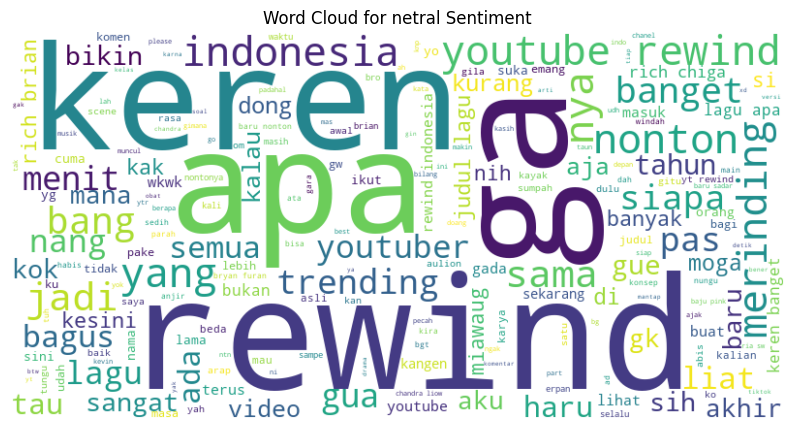

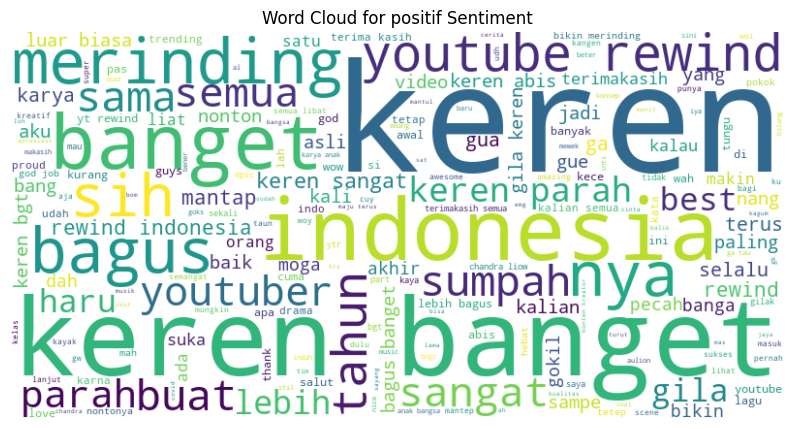

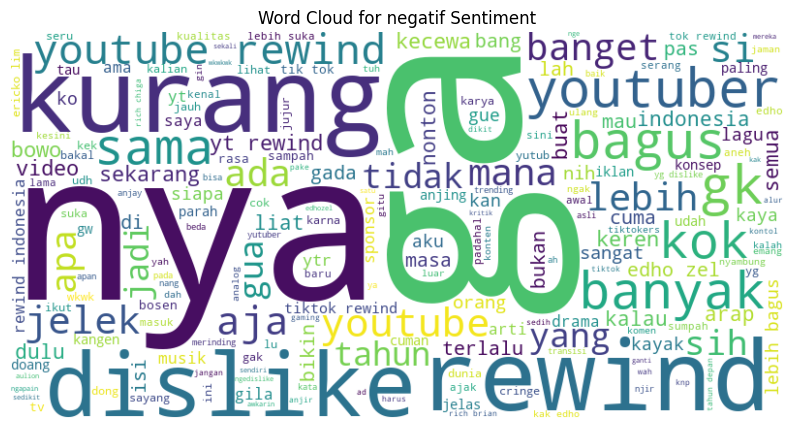

In [11]:
from wordcloud import WordCloud

# Generate word cloud for each sentiment
sentiments = ['netral', 'positif', 'negatif']
for sentiment in sentiments:
    text = ' '.join(df_train[df_train['label'] == sentiment]['textOriginal'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()


## Precision-Recall Curve

Berguna untuk mengevaluasi kinerja model klasifikasi, terutama ketika ada ketidakseimbangan kelas.

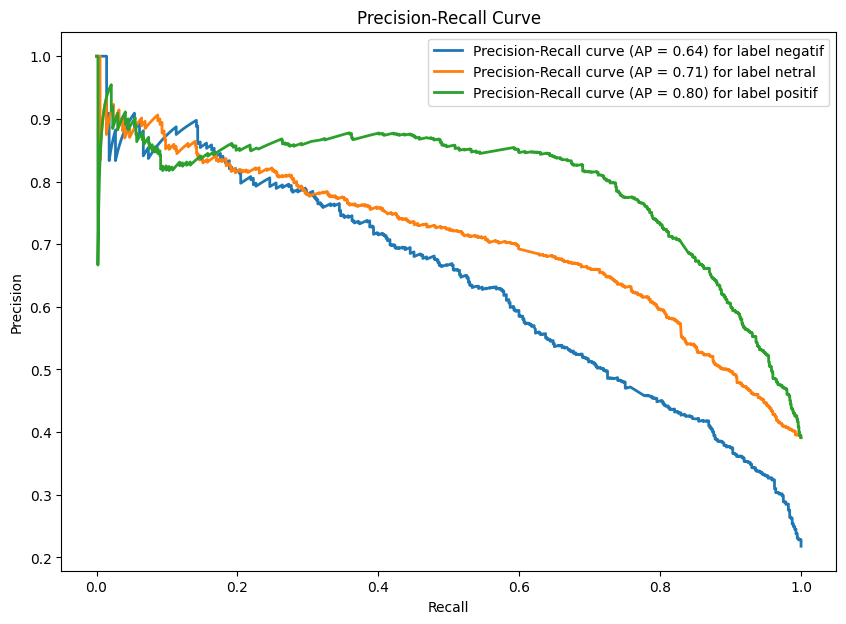

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i, label in enumerate(model.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f}) for label {label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()


## Distribusi kelas dari data training dan data testing

Menampilkan distribusi kelas dalam data pelatihan dan pengujian.

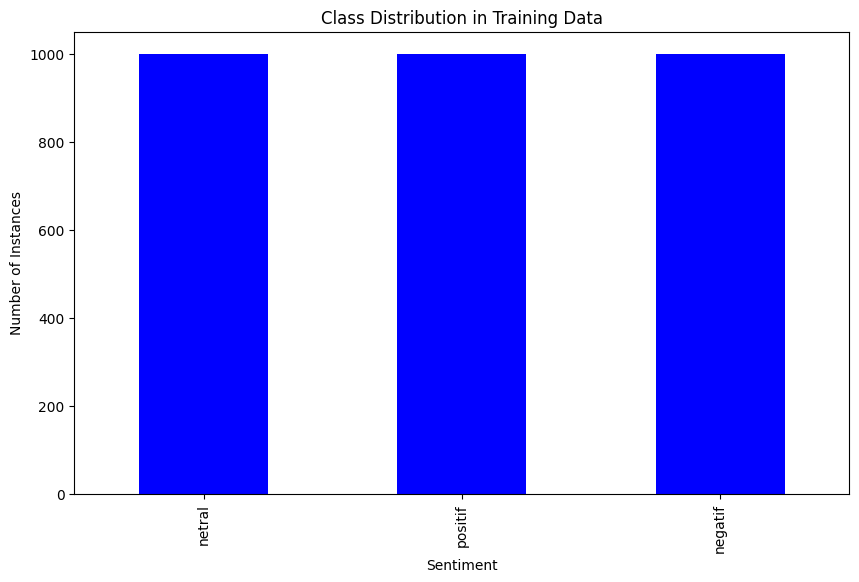

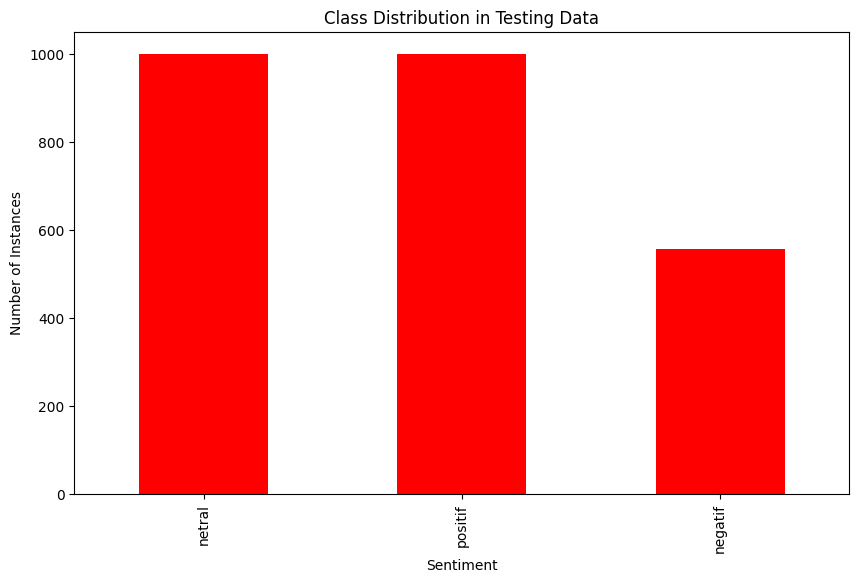

In [13]:
# Plot class distribution in training data
plt.figure(figsize=(10, 6))
df_train['label'].value_counts().plot(kind='bar', color='blue')
plt.xlabel('Sentiment')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Data')
plt.show()

# Plot class distribution in testing data
plt.figure(figsize=(10, 6))
df_test['label'].value_counts().plot(kind='bar', color='red')
plt.xlabel('Sentiment')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Testing Data')
plt.show()


## Learning Curve

Learning curve membantu memahami performa model berdasarkan ukuran data pelatihan.

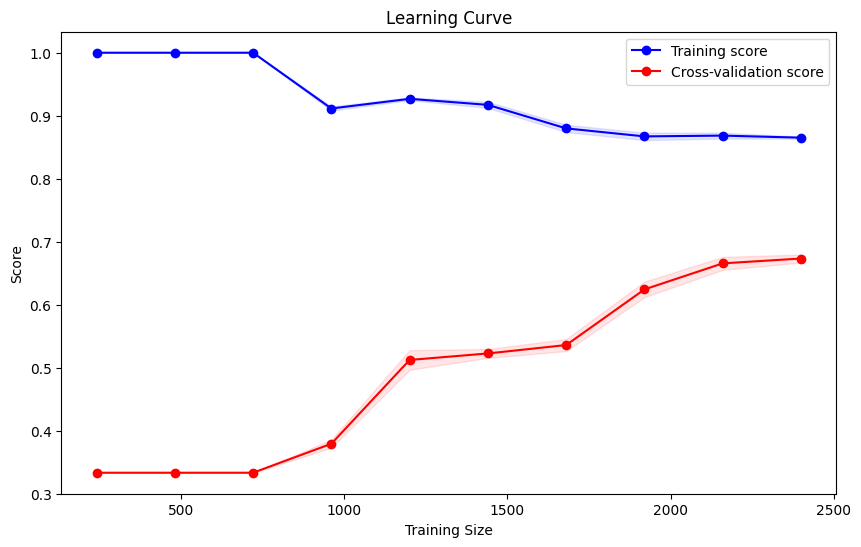

In [14]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Cross-validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)

plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


## Histogram distribusi probabilitas dari prediksi model

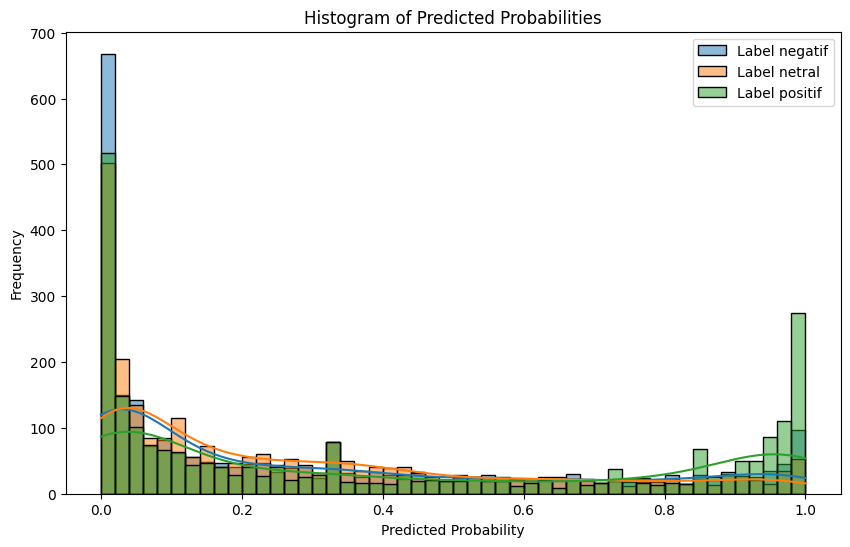

In [15]:
# Probabilities of the predictions
y_pred_proba = model.predict_proba(X_test)

plt.figure(figsize=(10, 6))
for i, label in enumerate(model.classes_):
    sns.histplot(y_pred_proba[:, i], bins=50, kde=True, label=f'Label {label}')
    
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.legend()
plt.show()


## Error Analysis

Menampilkan beberapa contoh teks yang salah diklasifikasikan oleh model.

In [16]:
# Adding predictions to the dataframe
df_test['predicted_label'] = y_pred

# Filtering the misclassified examples
misclassified = df_test[df_test['label'] != df_test['predicted_label']]

# Display some misclassified examples
print("Misclassified examples:")
print(misclassified[['textOriginal', 'label', 'predicted_label']].head(10))


Misclassified examples:
                                         textOriginal    label predicted_label
0                                  yang punya lagu gk  negatif          netral
1               tetap bikin merinding keren salam dri  negatif         positif
2      jancuk keren parahthe best youtubers indonesia  negatif         positif
3                                  enak nya pas akhir  negatif          netral
4             apa cuma gue ngerasa cepet sangat video  negatif          netral
9   yutub rewind gada bang yon mantap jiwa jadi ci...  negatif          netral
11                                 buat apa aku nanya  negatif          netral
13                                         tungu ples  negatif         positif
14           gw kesini cuma mau liat rich brian doang  negatif          netral
15            kak aulion mantap nyindir asap cara col  negatif          netral


## Kata-Kata yang Paling Berpengaruh untuk Setiap Kelas

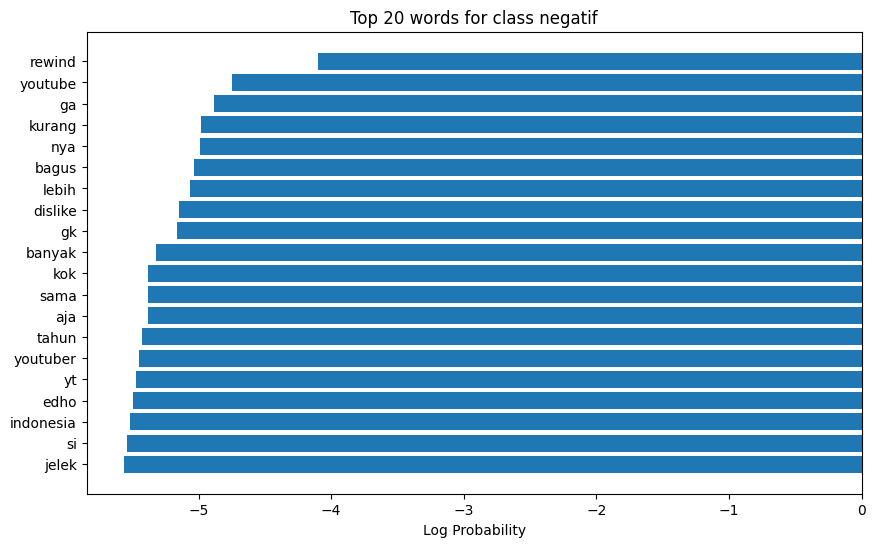

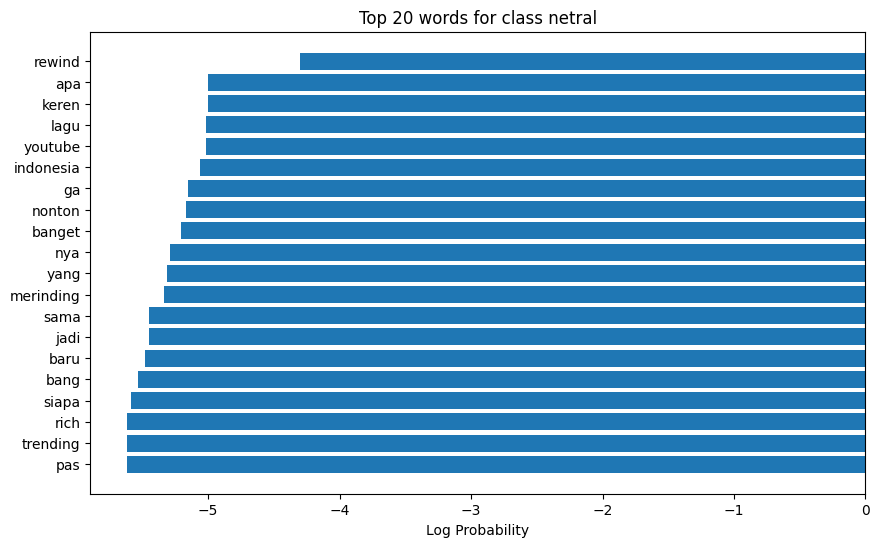

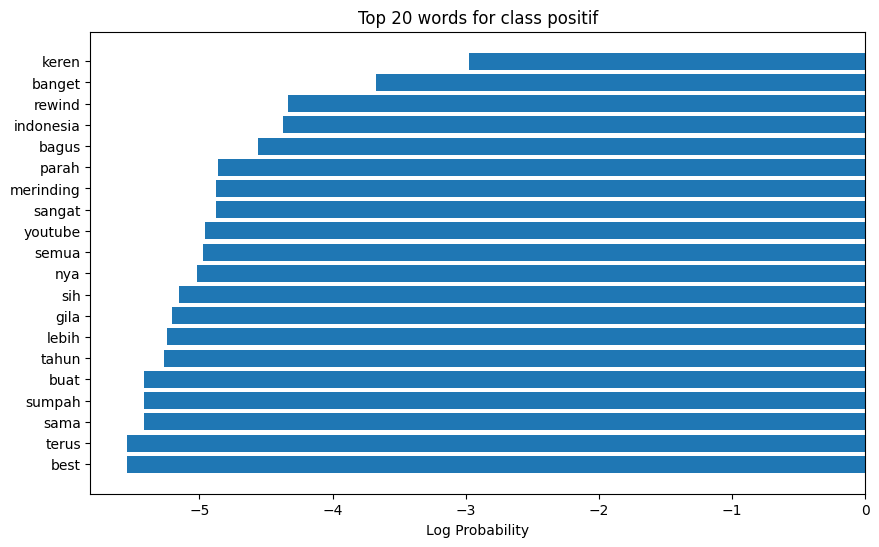

In [17]:
import numpy as np

# Extracting feature log probabilities
feature_log_prob = model.feature_log_prob_

# Extracting feature names
feature_names = vectorizer.get_feature_names_out()

# Function to plot top words
def plot_top_words(classifier, feature_names, class_labels, n_top_words=20):
    for i, class_label in enumerate(class_labels):
        top_features = np.argsort(classifier[i])[-n_top_words:]
        plt.figure(figsize=(10, 6))
        plt.barh(range(n_top_words), classifier[i][top_features], align='center')
        plt.yticks(np.arange(n_top_words), [feature_names[j] for j in top_features])
        plt.xlabel('Log Probability')
        plt.title(f'Top {n_top_words} words for class {class_label}')
        plt.show()

# Plot top words for each class
plot_top_words(feature_log_prob, feature_names, model.classes_)


# Visualisasi Data Untuk Data dengan Prediksi Label dari Model

## Mengambil data dari collection full_labeling_all (60.000 data)

In [18]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd

# Membuat koneksi ke MongoDB
client = MongoClient(local_url)
db = client[db_name]
full_labeling_all_collection = db[full_labeling_all_collection_name]

# Mengambil semua data dari koleksi MongoDB
data = list(full_labeling_all_collection.find())

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Mapping videoId dengan nama rewind
videoId_map = {
    "fNX6Gu2F7A8": "Rewind 2015",
    "1ZIGLm5cuDo": "Rewind 2016",
    "mCyITaDib7M": "Rewind 2018",
    "LhYfsKc0_tA": "Rewind 2020",
    "IPZO85HFM4w": "Rewind 2021",
    "Q5vQawTFJ0I": "Rewind 2023"
}

# Menambahkan kolom rewind_name berdasarkan videoId
df['rewind_name'] = df['videoId'].map(videoId_map)

## Stacked Bar Chart

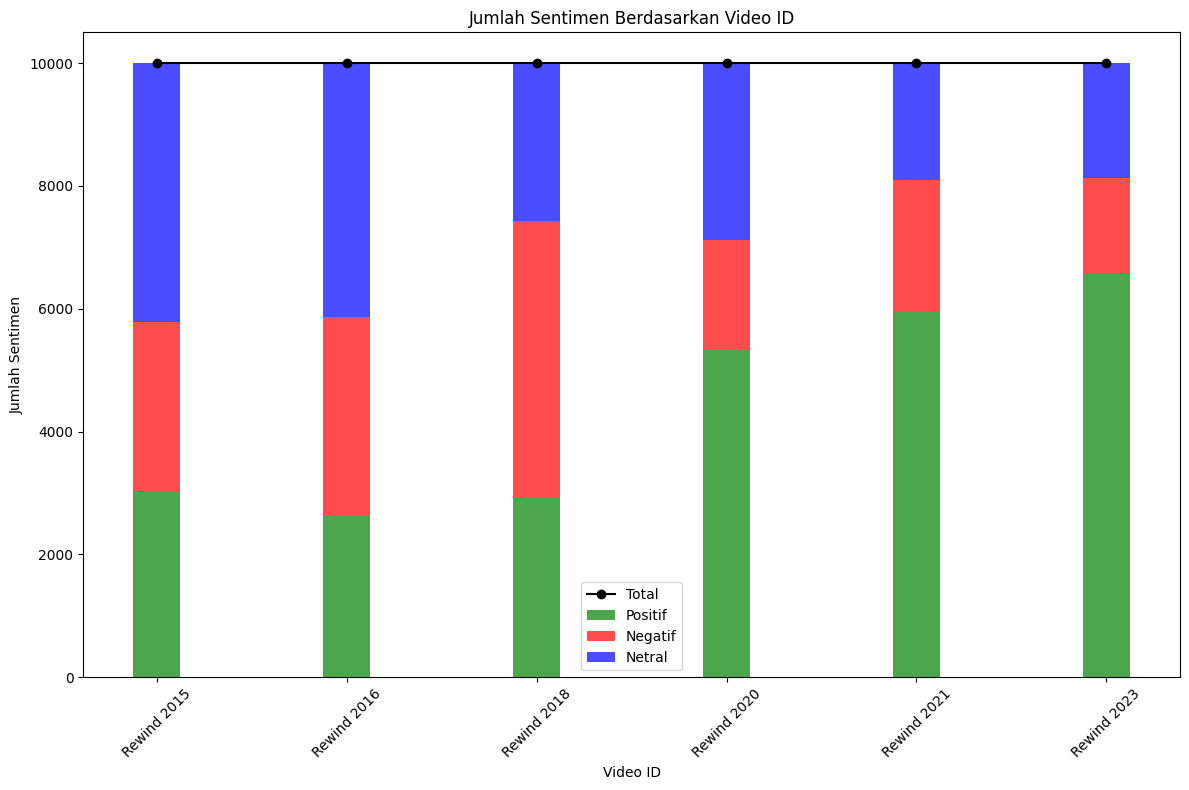

In [19]:
# Melakukan agregasi untuk menghitung jumlah sentimen berdasarkan rewind_name dan label
sentiment_counts = df.groupby(['rewind_name', 'predicted_label']).size().reset_index(name='count')

# Membuat pivot table untuk memformat data agar mudah digunakan untuk visualisasi
sentiment_pivot = sentiment_counts.pivot(index='rewind_name', columns='predicted_label', values='count').fillna(0)

# Mengurutkan berdasarkan nama rewind
sentiment_pivot = sentiment_pivot.reindex(index=list(videoId_map.values()))

# Plotting bar chart dan line chart
plt.figure(figsize=(12, 8))

# Bar chart untuk jumlah sentimen
bar_width = 0.25
labels = sentiment_pivot.index
x = range(len(labels))

plt.bar(x, sentiment_pivot['positif'], width=bar_width, label='Positif', color='green', alpha=0.7)
plt.bar(x, sentiment_pivot['negatif'], width=bar_width, label='Negatif', color='red', alpha=0.7, bottom=sentiment_pivot['positif'])
plt.bar(x, sentiment_pivot['netral'], width=bar_width, label='Netral', color='blue', alpha=0.7, bottom=sentiment_pivot['positif'] + sentiment_pivot['negatif'])

# Line chart untuk jumlah total sentimen
plt.plot(x, sentiment_pivot.sum(axis=1), marker='o', linestyle='-', color='black', label='Total')

plt.xlabel('Video ID')
plt.ylabel('Jumlah Sentimen')
plt.title('Jumlah Sentimen Berdasarkan Video ID')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


## Bar Chart dari Predicted Label

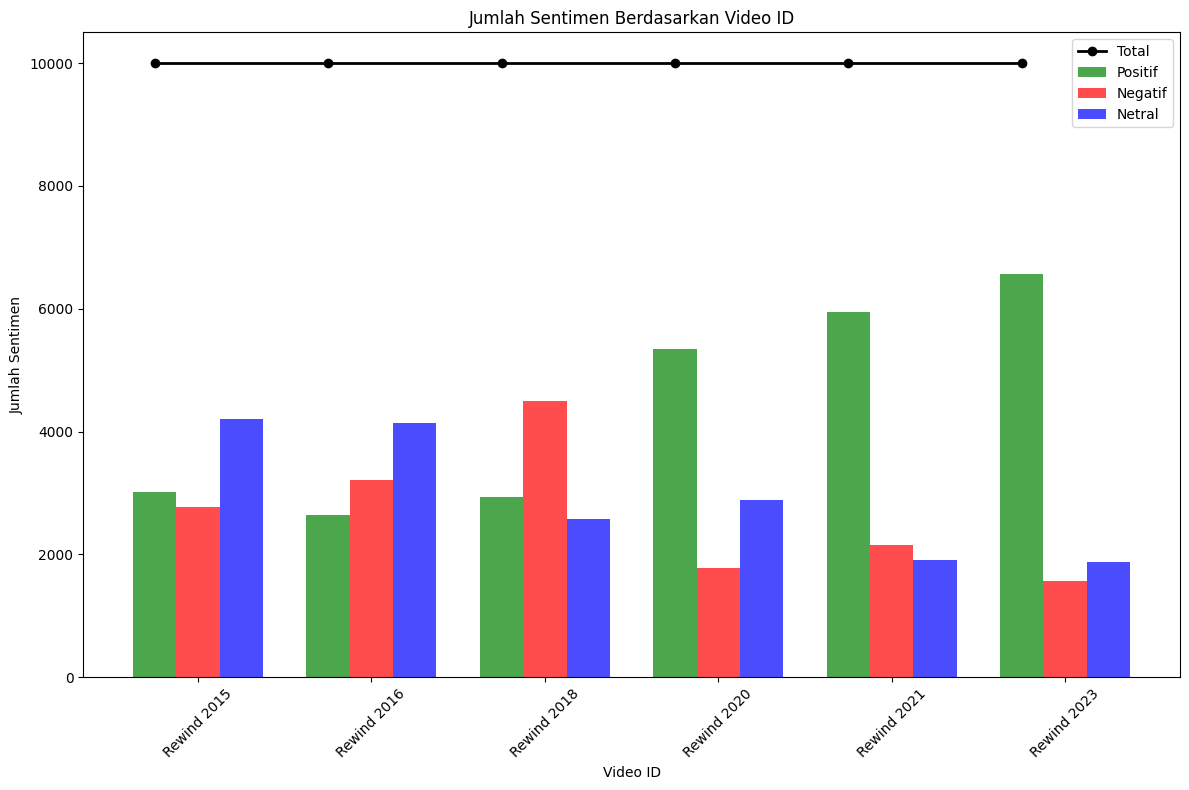

In [20]:
# Melakukan agregasi untuk menghitung jumlah sentimen berdasarkan rewind_name dan predicted_label
sentiment_counts = df.groupby(['rewind_name', 'predicted_label']).size().reset_index(name='count')

# Pivot table untuk memformat data agar mudah digunakan untuk visualisasi
sentiment_pivot = sentiment_counts.pivot(index='rewind_name', columns='predicted_label', values='count').fillna(0)

# Mengurutkan berdasarkan nama rewind
sentiment_pivot = sentiment_pivot.reindex(index=list(videoId_map.values()))

# Plotting bar chart untuk jumlah sentimen
plt.figure(figsize=(12, 8))

bar_width = 0.25
x = range(len(sentiment_pivot.index))

# Plot untuk sentimen positif
plt.bar(x, sentiment_pivot['positif'], width=bar_width, label='Positif', color='green', alpha=0.7)

# Plot untuk sentimen negatif
plt.bar([pos + bar_width for pos in x], sentiment_pivot['negatif'], width=bar_width, label='Negatif', color='red', alpha=0.7)

# Plot untuk sentimen netral
plt.bar([pos + 2 * bar_width for pos in x], sentiment_pivot['netral'], width=bar_width, label='Netral', color='blue', alpha=0.7)

# Line chart untuk total jumlah sentimen
plt.plot(x, sentiment_pivot.sum(axis=1), marker='o', linestyle='-', color='black', label='Total', linewidth=2)

plt.xlabel('Video ID')
plt.ylabel('Jumlah Sentimen')
plt.title('Jumlah Sentimen Berdasarkan Video ID')
plt.xticks([pos + bar_width for pos in x], sentiment_pivot.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


## Pie Chart Berdasarkan Tahun Rewind

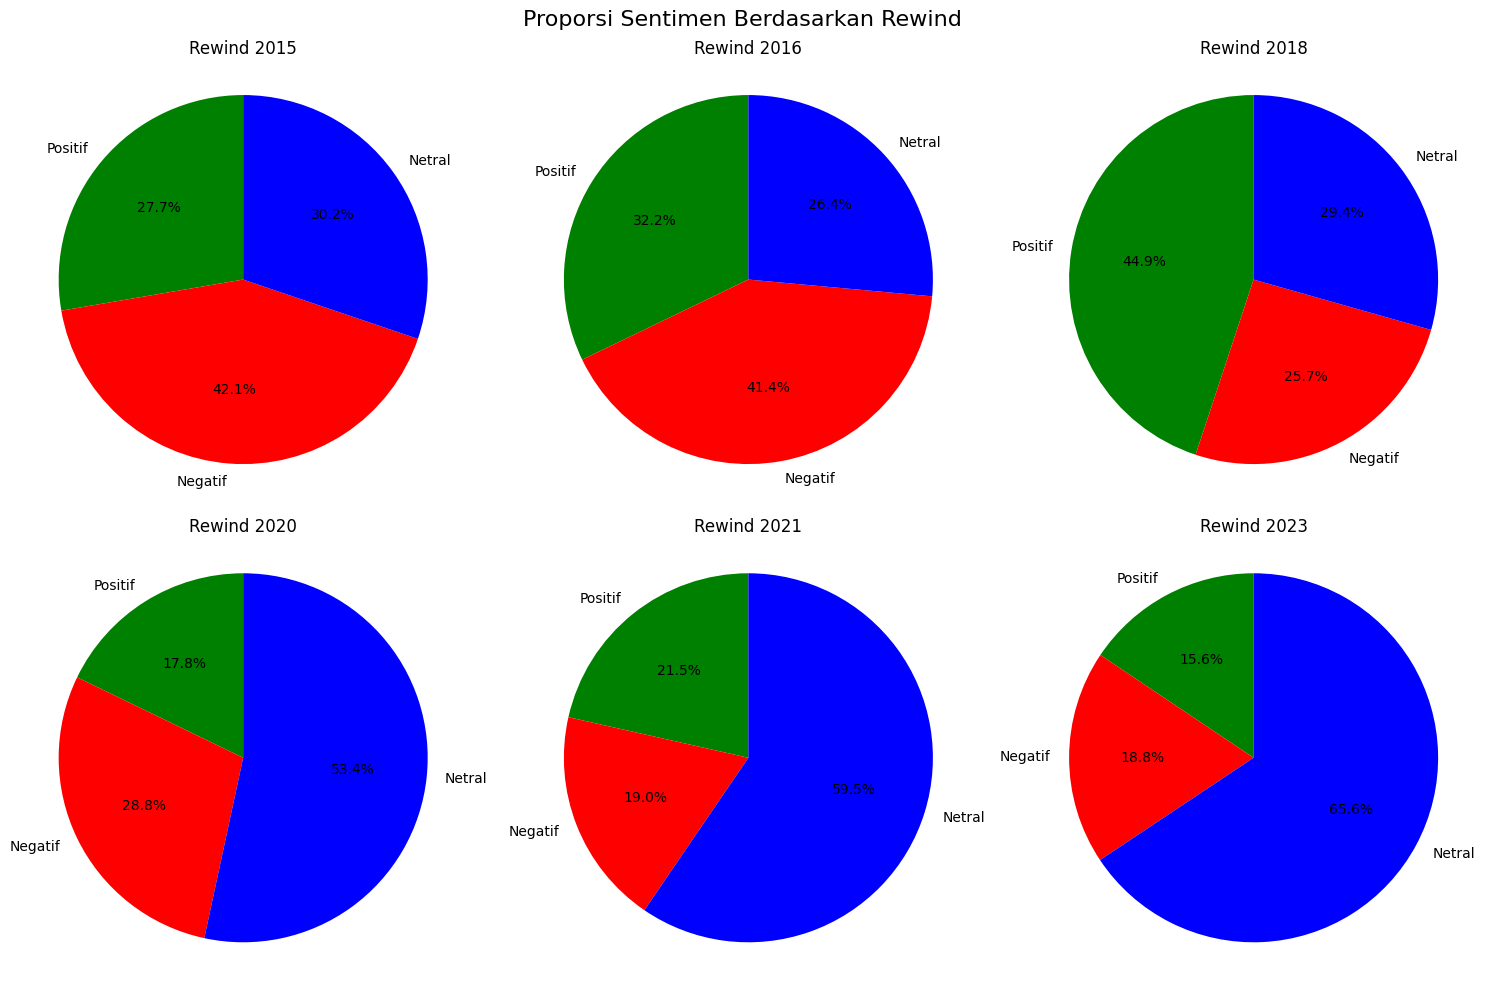

In [21]:
# Melakukan agregasi untuk menghitung jumlah sentimen berdasarkan rewind_name dan predicted_label
sentiment_counts = df.groupby(['rewind_name', 'predicted_label']).size().reset_index(name='count')

# Pivot table untuk memformat data agar mudah digunakan untuk visualisasi
sentiment_pivot = sentiment_counts.pivot(index='rewind_name', columns='predicted_label', values='count').fillna(0)

# Mengurutkan berdasarkan nama rewind
sentiment_pivot = sentiment_pivot.reindex(index=list(videoId_map.values()))

# Plotting pie chart untuk setiap rewind
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

colors = ['green', 'red', 'blue']
labels = ['Positif', 'Negatif', 'Netral']

for i, (rewind, row) in enumerate(sentiment_pivot.iterrows()):
    sizes = row.values
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(rewind)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.suptitle('Proporsi Sentimen Berdasarkan Rewind', fontsize=16)
plt.tight_layout()
plt.show()


## Histogram of Predicted Probabilities

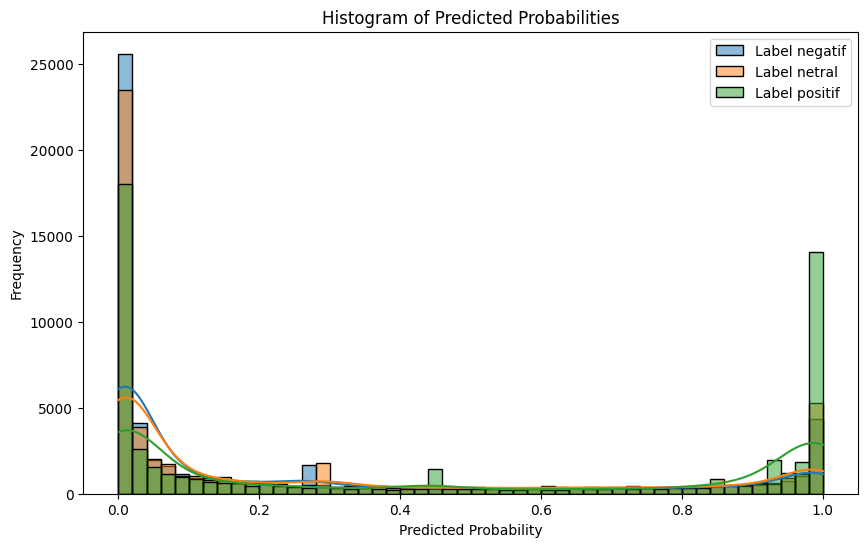

In [22]:
# Vectorizer
vectorizer = CountVectorizer(vocabulary=vectorizer.vocabulary_)

# Ubah teks menjadi fitur vektor
X = vectorizer.transform(df['textOriginal'])
y = df['predicted_label']

# Inisialisasi dan latih model Naive Bayes
model = MultinomialNB()
model.fit(X, y)

# Prediksi probabilitas
y_pred_proba = model.predict_proba(X)

# Plot histogram dari probabilitas prediksi
plt.figure(figsize=(10, 6))
for i, label in enumerate(model.classes_):
    sns.histplot(y_pred_proba[:, i], bins=50, kde=True, label=f'Label {label}')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.legend()
plt.show()

## Word Cloud

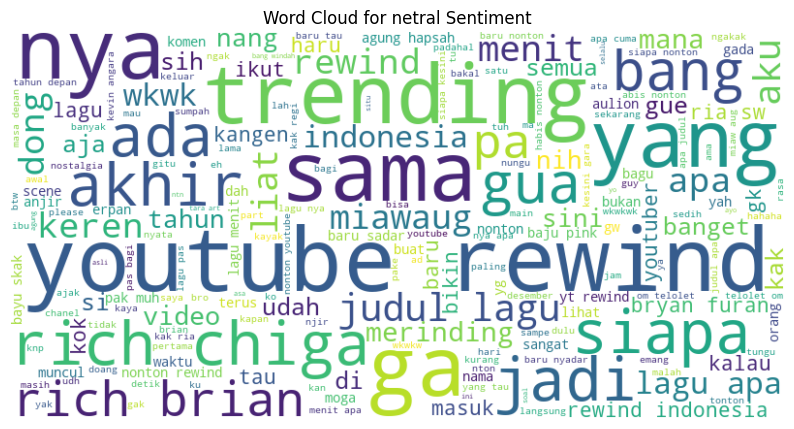

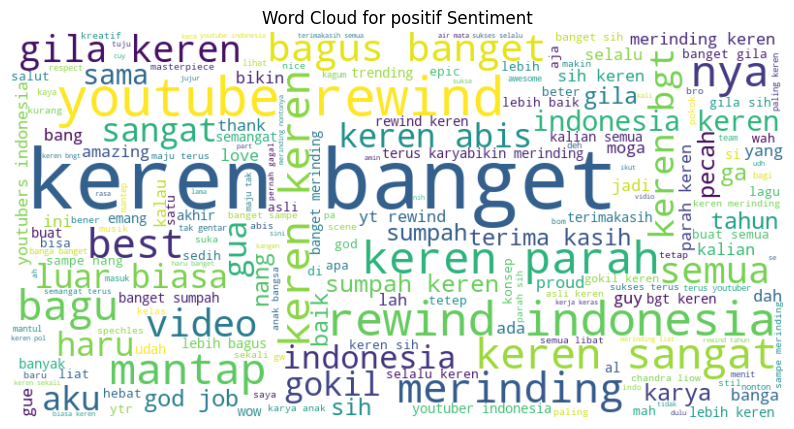

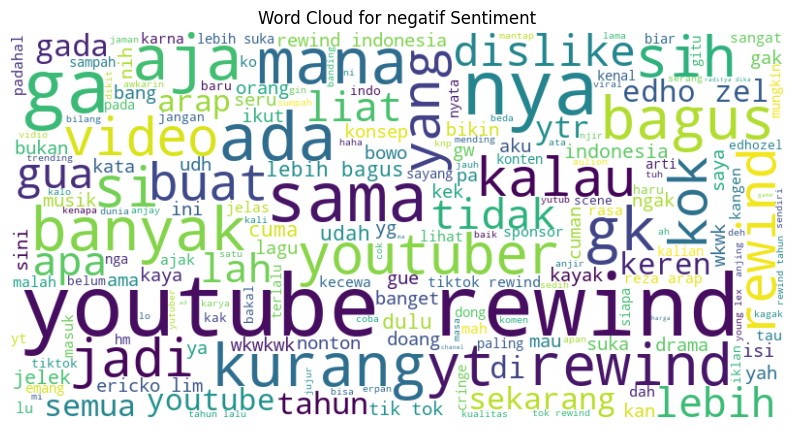

In [23]:
from wordcloud import WordCloud

# Generate word cloud for each sentiment
sentiments = ['netral', 'positif', 'negatif']
for sentiment in sentiments:
    text = ' '.join(df[df['predicted_label'] == sentiment]['textOriginal'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()
